## Library Imports

In [1]:
#import numpy as np
import tensorflow as tf
#import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix

import itertools
import os
import shutil
import random
from time import time
import matplotlib.pyplot as plt
#import pillow as pil
%matplotlib inline

In [2]:
DATA_PATH = 'SampleData'
#NUM_LAYERS_TO_REMOVE = 5
#NUM_LAYERS_TO_TRAIN = 20
LAYERS_TO_UNFREEZE = 120

## Create image pre-processing function

In [3]:
# Function to preprocess the image with Keras
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
#def image_preprocessing(file):
#    img = image.load_img(file, target_size=(224, 224))
#    img_array = image.img_to_array(img)
#    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
#    return tf.keras.applications.mobilenet_v3.preprocess_input(img_array_expanded_dims)

## Load the metadata file.  Create a ground truth column.

In [4]:
# Load the metadata file
#metadata = pd.read_excel('metadata_modified.xlsx')
#image_path = metadata['Image Path']
# Create the ground truth values and put it into a new 'g_truth' column
#g_truth = metadata['Malignant'] + metadata['A']*2 + metadata['F']*4 + metadata['PT']*8 + metadata['TA']*16 + metadata['DC']*32 + metadata['LC']*64 + metadata['MC']*128 + metadata['PC']*256
#metadata['g_truth'] = g_truth

## Display a test image

In [5]:
mobile_v3 = tf.keras.applications.MobileNetV3Large()
#preprocessed_image = image_preprocessing(image_path[7117])
#predictions = mobile_v3.predict(preprocessed_image)
#print("Output shape: ", predictions.shape)
#results = imagenet_utils.decode_predictions(predictions)
#results

Remove the specifiied number of layers.
Freeze the specified number of layers.

## Define the training and validation datasets

In [6]:
path_to_files = 'BreaKHis_v1/BreaKHis_v1/histology_slides/breast/'
  
train_dataset, holdout_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_files,
  labels = 'inferred',
  validation_split=0.25,
  subset="both",
  seed=42,
  image_size=(224, 224),
  batch_size=32,
  shuffle=True
)

# Get the labels from the train dataset



holdout_batches = len(holdout_dataset)
val_size = int(holdout_batches*0.6)
test_size = int(holdout_batches*0.4)

#classes = holdout_dataset.class_names

val_dataset = holdout_dataset.take(val_size)
test_dataset = holdout_dataset.skip(val_size).take(test_size)

print("Train dataset length: ", len(train_dataset))
print("Val dataset length: ", len(val_dataset))
print("Test dataset length: ", len(test_dataset))

#print("Holdout dataset class names: ", holdout_dataset.class_names)


Found 7909 files belonging to 8 classes.
Using 5932 files for training.
Using 1977 files for validation.
Train dataset length:  186
Val dataset length:  37
Test dataset length:  24


In [7]:
# Get labels

# print('Holdout dataset' + '-'*30)
# for images, labels in holdout_dataset.map(lambda x, y: (x, y)):
#     print(labels)

# print('Val dataset' + '-'*30)
# for images, labels in val_dataset.map(lambda x, y: (x, y)):
#     print(labels)

# print('Test dataset' + '-'*30)
# for images, labels in test_dataset.map(lambda x, y: (x, y)):
#     print(labels)

# print(len(val_dataset))
# print(len(test_dataset))

## Use AUTOTUNE to decrease I/O roadblocks

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Define the model

In [59]:
# Define the data augmenter

def data_augmenter():
    return tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    ])

In [60]:
IMG_SIZE=(224,224)
IMG_SHAPE = IMG_SIZE + (3,)
def new_model (image_shape=IMG_SIZE, fine_tune_at=120):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                                        include_top=False, # important
                                                        weights='imagenet')
    
    # freeze the base model
    base_model.trainable = True

    # freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # # unfreeze some layers
    # for layer in base_model.layers[-LAYERS_TO_UNFREEZE:]:
    #     #print("Unfreeze layer: ", layer.name)
    #     layer.trainable = True

    #print(base_model.summary())

    # create input layer
    inputs = tf.keras.Input(shape=input_shape)
    # pre-process inputs
    x = preprocess_input(inputs)

    x = data_augmenter()(x)
    # set training to False to avoid tracking statistics in batch norm layer
    x = base_model(x, training=False)
    # add flatten layer
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dense(8, activation='softmax')(x)

    outputs = x

    model = tf.keras.Model(inputs,outputs)
    return model

In [61]:
# Define the learning rate scheduler
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow_addons as tfa

def lr_scheduler(lr_transfer, lr_new, epoch_decay, layer_decay, model):
    optimizers_and_layers = []

    num_transfer_layers = 0
    num_new_layers = 0

    # Get count of all layers
    for layer in model.layers:
        if layer.name.startswith('Mobilenet'):
            for mobilenet_layer in layer.layers:
                num_transfer_layers += 1
        else:
            num_new_layers += 1

    print("Number of transfer layers: ", num_transfer_layers)
    print("Number of new layers: ", num_new_layers)

    # Get all the trainable layers
    for layer in model.layers:
        if layer.name.startswith('Mobilenet'):
            for mobilenet_layer in layer.layers:
                if mobilenet_layer.trainable:
                    schedule = ExponentialDecay(initial_learning_rate=lr_transfer, decay_steps=1, decay_rate=epoch_decay)
                    optimizers_and_layers.append((tf.keras.optimizers.legacy.Adam(learning_rate=schedule), mobilenet_layer))
                    
        elif layer.trainable:
            schedule = ExponentialDecay(initial_learning_rate=lr_new, decay_steps=1, decay_rate=epoch_decay)
            optimizers_and_layers.append((tf.keras.optimizers.legacy.Adam(learning_rate=schedule), layer))

    # Create the learning rate schedule
    optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

    return optimizer

## Train the model

In [77]:
def train_model(model, train_dataset, val_dataset, params):

    # Unpack parameters
    num_epochs = params['num_epochs']
    lr = params['lr']
    #lr_transfer = params['lr_transfer']
    #lr_new = params['lr_new']
    epoch_decay = params['epoch_decay']
    #layer_decay = params['layer_decay']


    #lr_schedule = lr_scheduler(lr_transfer, lr_new, epoch_decay, layer_decay, model)

    steps_per_epoch = len(train_dataset)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr, decay_steps=steps_per_epoch, decay_rate=epoch_decay)

    #optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.95, nesterov=True)

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

    history = model.fit(
        train_dataset, 
        epochs=num_epochs,
        verbose=1,
        validation_data=val_dataset)

    return history

In [78]:
# Training loop
import pandas as pd

run_set = pd.read_csv('Run_Set.csv')

for index, row in run_set.iterrows():
    if pd.isna(row['T1']):
        print(f"Training model {index+1} of {len(run_set)}")
        print('-'*30)

        # Pack parameters
        params = {}
        params['num_epochs'] = int(row['num_epochs'])
        params['lr'] = row['lr']
        #params['lr_transfer'] = row['lr_transfer']
        #params['lr_new'] = row['lr_new']
        params['epoch_decay'] = row['epoch_decay']
        #params['layer_decay'] = row['layer_decay']
        fine_tune_at = int(row['fine_tune_at'])

        # Create the model
        model = new_model(fine_tune_at=fine_tune_at)

        # Train the model
        history = train_model(model, train_dataset, val_dataset, params)

        # Save the model
        model.save(f"models/model_{index+1}.keras")

        # Write history to run set
        for epoch in range(params['num_epochs']):
            train_number = 'T' + str(epoch+1)
            run_set.at[index, train_number] = history.history['accuracy'][epoch]
            val_number = 'V' + str(epoch+1)
            run_set.at[index, val_number] = history.history['val_accuracy'][epoch]

        # Save the run set
        run_set.to_csv('Run_Set.csv', index=False)

        history_df = pd.DataFrame(history.history)
        history_df.to_csv(f"history/history_{index+1}.csv")

        print('-'*30)
        print(f"Model {index+1} of {len(run_set)} trained and saved")
        print('-'*30)
        print()


Training model 41 of 41
------------------------------


Epoch 1/10
186/186 [==============================] - 107s 559ms/step - loss: 1.5926 - accuracy: 0.4327 - val_loss: 1.3319 - val_accuracy: 0.5431
Epoch 2/10
186/186 [==============================] - 115s 612ms/step - loss: 1.1112 - accuracy: 0.6121 - val_loss: 0.8463 - val_accuracy: 0.6976
Epoch 3/10
186/186 [==============================] - 108s 577ms/step - loss: 0.8202 - accuracy: 0.7072 - val_loss: 1.0840 - val_accuracy: 0.6377
Epoch 4/10
186/186 [==============================] - 105s 560ms/step - loss: 0.6232 - accuracy: 0.7755 - val_loss: 0.6307 - val_accuracy: 0.7753
Epoch 5/10
186/186 [==============================] - 111s 591ms/step - loss: 0.4946 - accuracy: 0.8200 - val_loss: 0.5177 - val_accuracy: 0.8167
Epoch 6/10
186/186 [==============================] - 104s 556ms/step - loss: 0.3674 - accuracy: 0.8672 - val_loss: 0.4352 - val_accuracy: 0.8370
Epoch 7/10
186/186 [==============================] - 157s 842ms/step - loss: 0.2835 - accuracy: 0.8967 - val_loss: 0.4593 -

In [69]:
# num_epochs = 10
# lr = 0.0001
# epoch_decay = 1.0
# layer_decay = 1.0

# params = {
#     'num_epochs': num_epochs,
#     'lr': lr,
#     'epoch_decay': epoch_decay,
#     'layer_decay': layer_decay
# }

# model = new_model(IMG_SIZE)

# model.summary()

# history = train_model(model, train_dataset, val_dataset, params)

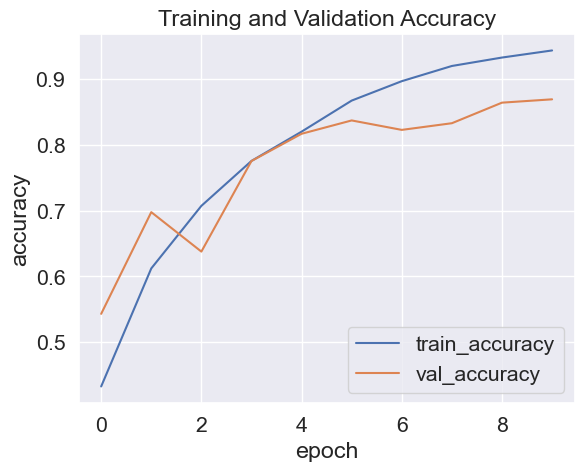

In [79]:
import numpy as np

# Load a saved model
#model = tf.keras.models.load_model('models/model_29.keras')


accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation accuracy per epoch
plt.plot(accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='val_accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()



24/24 [==============================] - 10s 323ms/step
F1 score binary: 0.9686346863468634
Precision score binary: 0.958029197080292
Recall score binary: 0.9794776119402985


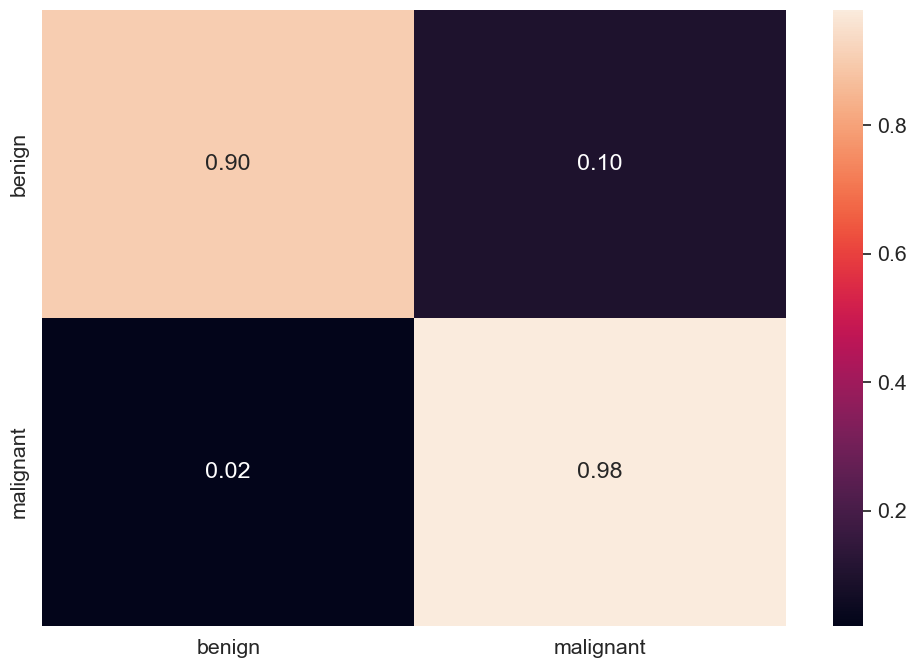

                     F1 score  Precision score  Recall score  Count
adenosis             0.800000         0.697674      0.937500    345
ductal_carcinoma     0.908356         0.846734      0.979651   2576
fibroadenoma         0.802395         0.881579      0.736264    753
lobular_carcinoma    0.540000         0.729730      0.428571    468
mucinous_carcinoma   0.816327         0.882353      0.759494    594
papillary_carcinoma  0.884211         0.933333      0.840000    437
phyllodes_tumor      0.769231         0.813953      0.729167    331
tubular_adenoma      0.840336         0.862069      0.819672    428


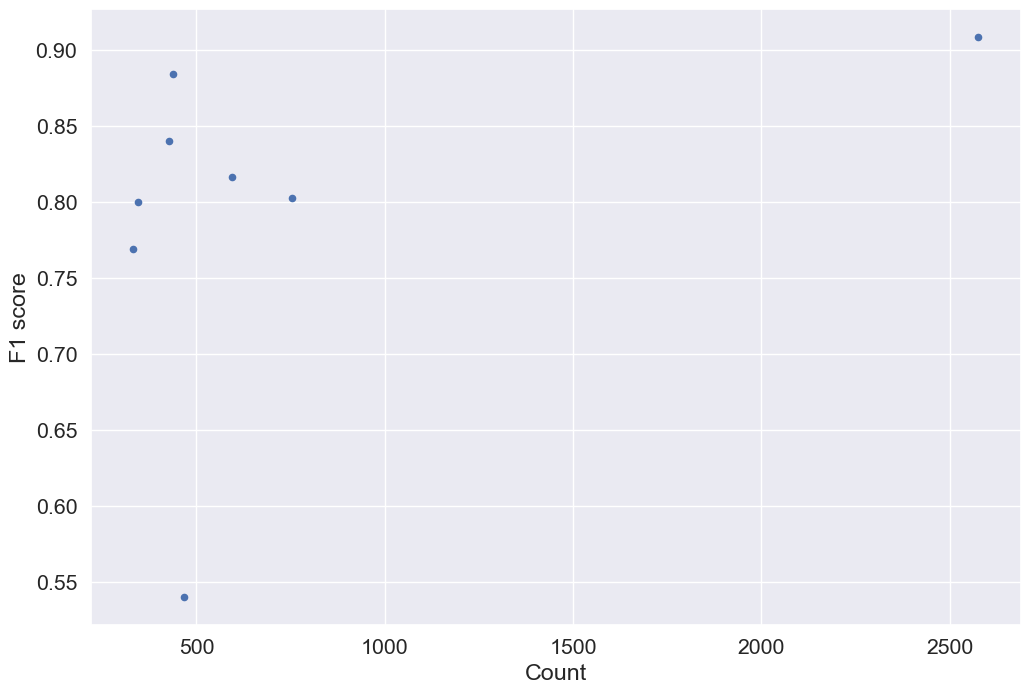

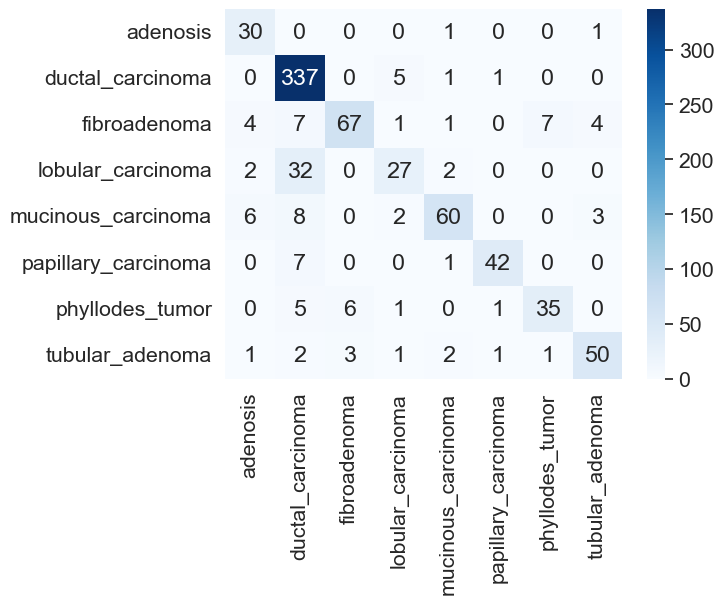

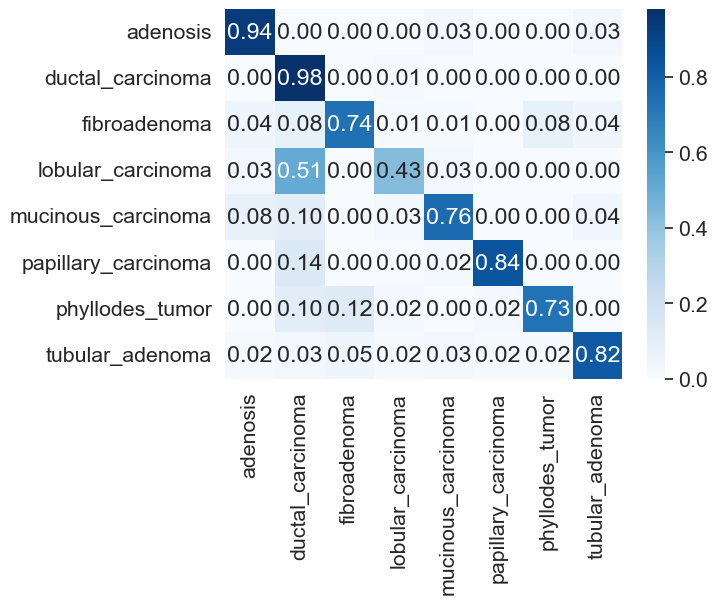

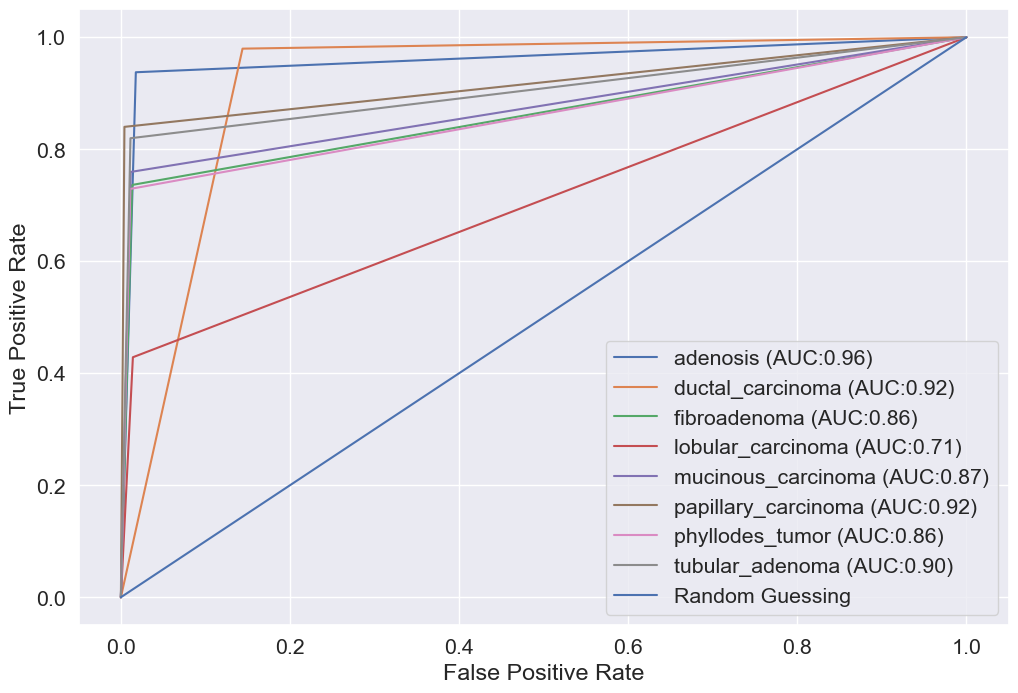

ROC AUC score: 0.8751933534662418


In [83]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, precision_score, recall_score

import pandas as pd
import seaborn as sns

target = ['adenosis', 'ductal_carcinoma', 'fibroadenoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma', 'phyllodes_tumor', 'tubular_adenoma']

target_binary = ['benign', 'malignant']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

ypred_raw = model.predict(test_dataset)
ypred = ypred_raw.argmax(axis=-1)

y_binary_pred = [i in [1, 3, 4, 5] for i in ypred]

# Get ground truth from test set
ytest = []
for images, labels in test_dataset.map(lambda x, y: (x, y)):
    ytest += labels.numpy().tolist()

y_binary_test = [i in [1, 3, 4, 5] for i in ytest]

f1_score_binary = f1_score(y_binary_test, y_binary_pred)
print('F1 score binary:', f1_score_binary)
precision_score_binary = precision_score(y_binary_test, y_binary_pred)
print('Precision score binary:', precision_score_binary)
recall_score_binary = recall_score(y_binary_test, y_binary_pred)
print('Recall score binary:', recall_score_binary)

cm_binary = confusion_matrix(y_binary_test, y_binary_pred)
cm_binary_normalize = cm_binary.astype('float') / cm_binary.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_binary_normalize, annot=True, fmt='.2f', xticklabels=target_binary, yticklabels=target_binary)
plt.show()


# Get ground truth from train_dataset
ytrain = []
for images, labels in train_dataset.map(lambda x, y: (x, y)):
    ytrain += labels.numpy().tolist()

# Get count of each label in the ytrain
ytrain_count = [ytrain.count(i) for i in range(len(target))]


f1_score = f1_score(ytest, ypred, average=None)
precision_score = precision_score(ytest, ypred, average=None)
recall_score = recall_score(ytest, ypred, average=None)

# Compile the scores into a dataframe
scores_df = pd.DataFrame({'F1 score': f1_score, 'Precision score': precision_score, 'Recall score': recall_score, 'Count': ytrain_count}, index=target)
print(scores_df)

# Plot f1_score vs count
scores_df.plot(kind='scatter', x='Count', y='F1 score', figsize=(12, 8))
plt.show()

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, ypred)

# Make a chart of the confusion matrix using sns.heatmap
import seaborn as sns
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=target, yticklabels=target)
plt.show()

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=target, yticklabels=target)
plt.show()


# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    
    fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')

    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()


    return roc_auc_score(y_test, y_pred, average=average)

roc_score = multiclass_roc_auc_score(ytest, ypred)
print('ROC AUC score:', roc_score)


In [81]:
model2 = tf.keras.models.load_model('models/model_41.keras')

AttributeError: 'SGD' object has no attribute 'build'

/var/folders/v3/6g8j12qj0yd6zlbh6nr578p80000gn/T/ipykernel_92994/2160961354.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


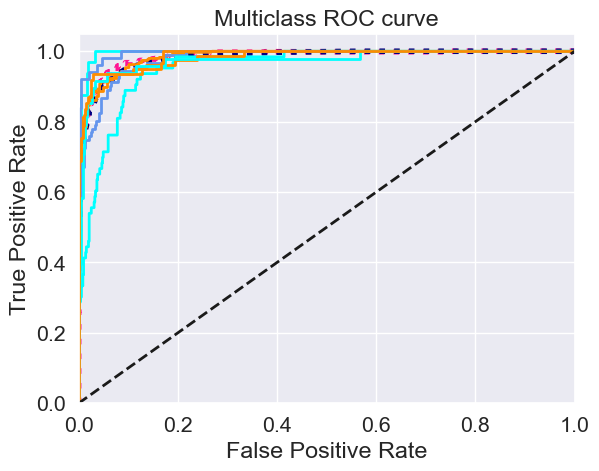

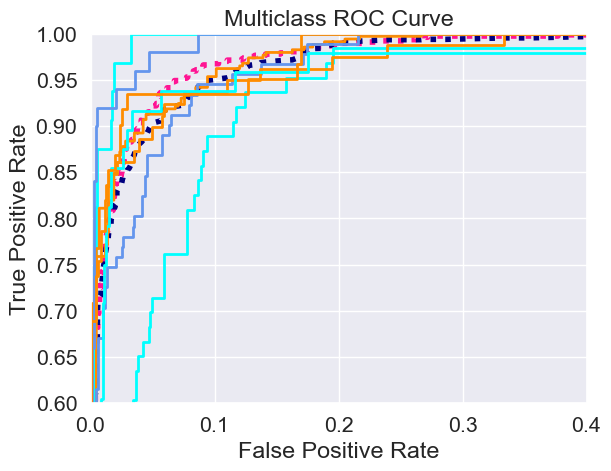

In [91]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

n_classes = len(target)

# Plot linewidth.
lw = 2

lb = LabelBinarizer()
lb.fit(ytest)
ytest_lb = lb.transform(ytest)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest_lb[:, i], ypred_raw[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ytest_lb.ravel(), ypred_raw.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of class {target[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC curve')
#plt.legend(loc="lower right")
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.4)
plt.ylim(0.6, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
#plt.legend(loc="lower right")
plt.show()
